In [ ]:
# Import torch
import torch

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

# Setup random seed
RANDOM_SEED = 42


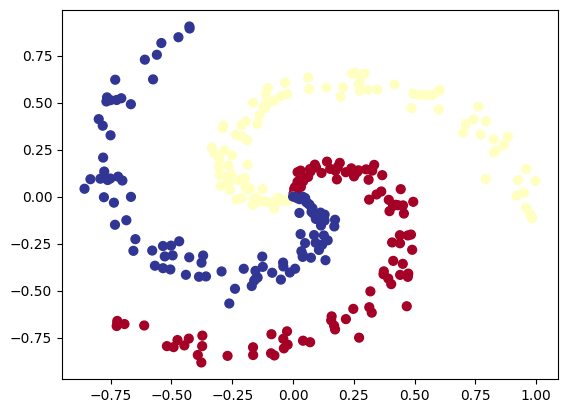

In [47]:
# spiral dataset from CS231n
import numpy as np
import matplotlib.pyplot as plt
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
# lets visualize the data
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
plt.show()

In [48]:
import torch
X = torch.from_numpy(X).type(torch.float) # features as float32
y = torch.from_numpy(y).type(torch.LongTensor) # labels need to be of type long

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, train_size=0.8)
len(X_test),len(X_train),len(y_test),len(y_train)


(60, 240, 60, 240)

In [49]:

from torchmetrics import Accuracy

## TODO: uncomment the two lines below to send the accuracy function to the device
acc_fn = Accuracy(task="multiclass", num_classes=4).to(device)
acc_fn

MulticlassAccuracy()

In [58]:
class MultiClassModel(nn.Module):
  def __init__(self):
    super().__init__()

    self.layer_1 = nn.Linear(in_features=2,out_features=24)
    self.layer_2 = nn.Linear(in_features=24,out_features=24)
    self.layer_3 = nn.Linear(in_features=24,out_features=24)
    self.layer_4 = nn.Linear(in_features=24,out_features=3)
    self.relu = nn.ReLU()

  def forward(self,x):

    return self.layer_4(self.relu(self.layer_3(self.relu((self.layer_2(self.relu(self.layer_1(x))))))))

model_1 = MultiClassModel().to(device)
model_1

MultiClassModel(
  (layer_1): Linear(in_features=2, out_features=24, bias=True)
  (layer_2): Linear(in_features=24, out_features=24, bias=True)
  (layer_3): Linear(in_features=24, out_features=24, bias=True)
  (layer_4): Linear(in_features=24, out_features=3, bias=True)
  (relu): ReLU()
)

In [68]:
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

print("Logits:")
print(model_1(X_train)[:10])

print("Pred probs:")
print(torch.softmax(model_1(X_train)[:10], dim=1))

print("Pred labels:")
print(torch.softmax(model_1(X_train)[:10], dim=1).argmax(dim=1))

print(X_train.dtype,X_test.dtype,y_train.dtype,y_test.dtype)


Logits:
tensor([[ 0.0871,  0.0023, -0.2381],
        [ 0.0714, -0.0138, -0.2188],
        [ 0.0995, -0.0050, -0.2389],
        [ 0.0830, -0.0023, -0.2316],
        [ 0.0995, -0.0075, -0.2074],
        [ 0.1232, -0.0041, -0.2522],
        [ 0.0948,  0.0054, -0.2245],
        [ 0.0935,  0.0014, -0.2093],
        [ 0.0734, -0.0078, -0.2362],
        [ 0.1064, -0.0062, -0.2481]], device='cuda:0',
       grad_fn=<SliceBackward0>)
Pred probs:
tensor([[0.3786, 0.3479, 0.2735],
        [0.3750, 0.3444, 0.2806],
        [0.3826, 0.3446, 0.2728],
        [0.3776, 0.3467, 0.2757],
        [0.3796, 0.3411, 0.2793],
        [0.3895, 0.3429, 0.2676],
        [0.3786, 0.3462, 0.2751],
        [0.3772, 0.3441, 0.2787],
        [0.3765, 0.3472, 0.2763],
        [0.3853, 0.3443, 0.2703]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
Pred labels:
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
torch.float32 torch.float32 torch.int64 torch.int64


In [69]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_1.parameters(),lr=0.1)

In [73]:

epochs = 1000
for epoch in range(epochs):

  ## Training
  model_1.train()
  logits = model_1(X_train)
  logits_pred = torch.softmax(logits,dim=1)
  logits_labels = logits_pred.argmax(dim=1)

  loss = loss_fn(logits,y_train)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  ## Testing
  model_1.eval()
  with torch.inference_mode():
    logits_test = model_1(X_test)
    logits_pred_test = torch.softmax(logits_test,dim=1)
    logits_labels_test = logits_pred_test.argmax(dim=1)

    loss_test = loss_fn(logits_test,y_test)
    acc_test = acc_fn(logits_labels_test,y_test.int())
  if epoch % 100 == 0:
    print(f"loss:{loss} | test_loss:{loss_test} |  test_acc :{acc_test}")

loss:0.05346224084496498 | test_loss:0.07223937660455704 |  test_acc :0.9833333492279053
loss:0.04850766807794571 | test_loss:0.0652688592672348 |  test_acc :0.9833333492279053
loss:0.04455030709505081 | test_loss:0.060284413397312164 |  test_acc :0.9833333492279053
loss:0.04158565029501915 | test_loss:0.056546688079833984 |  test_acc :0.9833333492279053
loss:0.039027273654937744 | test_loss:0.053313951939344406 |  test_acc :0.9833333492279053
loss:0.03711053356528282 | test_loss:0.05093022435903549 |  test_acc :0.9833333492279053
loss:0.03537972643971443 | test_loss:0.04859381169080734 |  test_acc :0.9833333492279053
loss:0.033650122582912445 | test_loss:0.04625844210386276 |  test_acc :0.9833333492279053
loss:0.03189663961529732 | test_loss:0.043652892112731934 |  test_acc :0.9833333492279053
loss:0.0304966289550066 | test_loss:0.041559938341379166 |  test_acc :0.9833333492279053


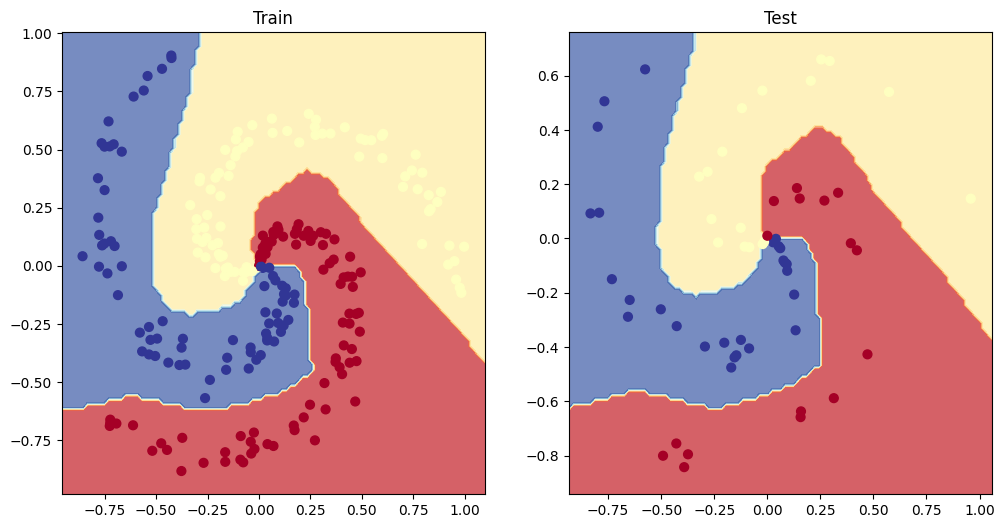

In [75]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)